# Conditional Deep Convolutional GAN using MXNet
**For detailed explanation, refer my article [here](https://medium.com/@suyashdamle/nuts-and-bolts-of-conditional-deep-convolutional-gans-58f6b9b8106a).**

***

In [ ]:
import numpy as np
import mxnet as mx 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from IPython.display import clear_output
print(os.listdir("../input"))
print(mx.test_utils.list_gpus())

# Any results you write to the current directory are saved as output.

## Figuring out the data format and making it usable

In [ ]:
train_data_ = pd.read_csv('../input/mnist_train.csv')
test_data_ = pd.read_csv('../input/mnist_test.csv')

In [ ]:
print(train_data_.head())

In [ ]:
train_label = train_data_['label']
test_label = test_data_['label']
train_data = train_data_.drop(columns='label').values
test_data = test_data_.drop(columns='label').values
train_data = np.concatenate((train_data,test_data),axis = 0)
train_label = np.concatenate((train_label, test_label),axis =0)
train_data = mx.nd.array(train_data)
print(train_data.shape)

### Trying to recreate the images

In [ ]:
def get_image(mat):
    mat = mat.reshape((28,28))/255.0
    print(mat.shape)
    plt.imshow(mat.asnumpy(),cmap = 'gray')
    plt.show
    
def get_sturctured_images(data):
    # convert to batch_size X width X height form
    data = data.reshape((-1,28,28))
    return (data/255.0)

# plot the image at this index:
idx = 4
get_image(train_data[idx])
train_data = get_sturctured_images(train_data)
    

## Getting a few required helper code-segments in place

### Function for concatenating images with label-representations appropriately

In [ ]:
def concat_img_label(imgs, labels):
    '''
    concatenates 28X28 images with their suitably represented labels
    '''
    imgs = imgs.as_in_context(ctx).reshape((-1,1,28,28))
    labels = mx.ndarray.one_hot(mx.nd.array(labels),10).expand_dims(axis=2)
    labels = labels.broadcast_to((labels.shape[0],10,10))
    labels = np.tile(labels.asnumpy(), reps=(1,2,2))
    labels = np.pad(labels, mode='constant',constant_values = 0.,pad_width=((0,0),(4,4),(4,4)))
    img_label = mx.ndarray.concat(imgs, mx.nd.array(labels).as_in_context(ctx).expand_dims(axis=1) , dim =1)  # along the 'channel dimension' in NCHW format
    return [img_label]

### The custom image/random sample iterators for generator and discriminator
- **For generator**: (creates set of fake images in NCHW format ; 2nd channel being label encodings)
    - Generate random integers between 0 and 9 (of 1 X batch_size shape). These would be our labels for fake images
    - Convert these into one-hot encoding : --> (batch_size, 10 )
    - Broadcast to (batch_size X 10 X 10 shape) --> (batch_size, 10, 10)
    - Add another dimension for channel: --> (batch_size, 1, 10, 10)
    - Generate a 10X10 noise matrix using mx.random.normal() --> (batch_size, 1, 10, 10)
    - Concatenate the label encodings with noise: --> (batch_size, 2, 10, 10)

In [ ]:
class GenInputIter(mx.io.DataIter):
    def __init__(self, batch_size, dim_x, dim_y):
        self.batch_size = batch_size
        self.ndim = (dim_x,dim_y)
        self.provide_data = [('rand_label', (batch_size, 2, dim_x, dim_y))]
        self.provide_label = [('labels',(batch_size,))]
    def iter_next(self):
        return True
    def __iter__(self):
        return self
    def __next__(self):
        return self.next()
    def reset(self):
        self.current_batch = 0
    def next(self):
        # NOTE: make sure batch_size divides total sample size. Else, make changes in slicing op.
        labels = mx.ndarray.random.randint(0,10,shape=(batch_size,))
        rand = mx.random.normal(0, 1.0, shape=(self.batch_size ,
                                               1, self.ndim[0], self.ndim[1]))
        gen_label = mx.ndarray.one_hot(mx.nd.array(labels),10).expand_dims(axis=2)
        gen_label = gen_label.broadcast_to((self.batch_size,
                                            self.ndim[0], self.ndim[1])).expand_dims(axis=1)
        gen_label_batch = mx.ndarray.concat(rand, gen_label, dim =1)  # along the 'channel dimension' in NCHW format
        data = [gen_label_batch.as_in_context(ctx)]
        label = [labels.as_in_context(ctx)]
        # to visualize the 2 channels:
#         fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,4))
#         ax1.imshow(rand[0].asnumpy().reshape(10,10),cmap='gray')
#         ax2.imshow(gen_label[0].asnumpy().reshape(10,10),cmap='gray')
#         ax1.title.set_text('Noise(Ch.1)')
#         ax2.title.set_text('Label Encoding(Ch.2), (label = '+str(label[0][0].asnumpy())+' )')
#         plt.show()
        return mx.io.DataBatch(data),label

- **For Discriminator**: (creates a set of real images in NCHW format; 2nd channel being label encodings)
    - The function *concat_img_label()* handles this.
    - Convert labels into one-hot encoding : --> (batch_size, 10 )
    - Broadcast to (batch_size X 10 X 10 shape) --> (batch_size, 10, 10)
    - Tile along each axes --> (batch_size, 20, 20)
    - Pad four 0's on each side along both axes --> (batch_size, 28, 28)
    - Add another dimension for channel: --> (batch_size, 1, 28, 28)
    - Take a batch of real MNIST images --> (batch_size, 1, 28, 28)
    - Concatenate the label encodings with images: --> (batch_size, 2, 28, 28)

In [ ]:
class DiscInputIter(mx.io.DataIter):
    def __init__(self, batch_size, data, label):
        assert batch_size<=data.shape[0], 'Batch size exceeds input'
        self.batch_size = batch_size
        self.ndim = 28
        self.provide_data = [('data', (batch_size, 2, 28, 28))]
        self.provide_label = []
        self.current_batch = 0
        self.data = concat_img_label(data,label)[0]
        
    def iter_next(self):
        return True
    def reset(self):
        self.current_batch = 0
    def next(self):#getdata
        #Returns images: batch_sizeX28X28 ...
        # ... concatenated to the label
        # NOTE: make sure batch_size divides total sample size. Else, make changes in slicing op.
        if self.current_batch + batch_size >= self.data.shape[0]:
            raise StopIteration
        else:
            img_label_batch = self.data[self.current_batch:self.current_batch+batch_size]
            self.current_batch = (self.current_batch+batch_size)%(self.data.shape[0])
            return mx.io.DataBatch([img_label_batch])

### A function to visualize our generator's outputs periodically

In [ ]:
def render(wait_at_sample=True,plot_binarized=False, text=None, animate_frames=None):
    # do a conditional forward-pass on Generator and view result
    labels = range(10)
    labels = mx.ndarray.one_hot(mx.nd.array(labels),10).expand_dims(axis=2)
    rand = mx.random.normal(0, 1.0, shape=(10 , 1, 10,10))
    gen_label_batch = labels.broadcast_to((10, 10,10)).expand_dims(axis =1)
    gen_label_batch = mx.ndarray.concat(rand, gen_label_batch , dim =1)  # along the 'channel dimension' in NCHW format
    generator.forward(mx.io.DataBatch([gen_label_batch]),is_train=False)
    outG = generator.get_outputs()[0]
        
    # now, plot these:
    w=15
    h=5
    fig=plt.figure(figsize=(8, 4))
    columns = 5
    rows = 2
    thresh = 0.7
    for i in range(1, columns*rows +1):
        ax = fig.add_subplot(rows, columns, i,label=str(i))
        ax.title.set_text(str(i-1))
        img = outG[i-1].asnumpy().reshape((28,28))
        if plot_binarized:
            img[img<thresh]=0.
            img[img>=thresh]=1.
        im = plt.imshow(img,cmap='gray')
        plt.axis('off')
    plt.suptitle(text)

    if animate_frames is not None:
        fig.canvas.draw()       # draw the canvas, cache the renderer
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        animate_frames.append(image)
    if wait_at_sample:
        plt.show()
        input()
    else:
        plt.close(fig)    # close the figure
    if animate_frames:
        return animate_frames

## The model hyper-parameters

In [ ]:
# The model specifics
ctx = mx.gpu(0)
#Hyper-parameters
sigma = 0.02
lr_gen = 0.001#0.001
lr_disc = 0.001
beta1 = 0.7#0.9
beta2 = 0.4#0.7
batch_size = 20  # keep this st. it divides the total no. of samples : 70k


***
***

## The Generator & Discriminator models

In [ ]:
# The Generator Module
def gen_module():
    # just create the generator module and return it
    # it would generate an image from some random number
    fix_gamma = False
    epsilon = 1e-5 + 1e-12
    
    rand_label = mx.sym.Variable('rand_label')
    # gen_label = mx.sym.Variable('gen_label')
    # convert the label to 10 X 10 matrix and concatenate as the second channel to random matrix
    # input: 10 X 10 X 2 for each image
    
    g1 = mx.sym.Deconvolution(rand_label, name='g1', kernel=(5,5), num_filter=256)
    gbn1 = mx.sym.BatchNorm(g1, name='gbn1', fix_gamma=fix_gamma, eps=epsilon)
    gact1 = mx.sym.Activation(gbn1, name='gact1', act_type='relu')
    # ---> 14 X 14 X 256 (each)
    
    g2 = mx.sym.Deconvolution(gact1, name='g2', kernel=(5,5), num_filter=256)#7
    gbn2 = mx.sym.BatchNorm(g2, name='gbn2', fix_gamma=fix_gamma, eps=epsilon)
    gact2 = mx.sym.Activation(gbn2, name='gact2', act_type='relu')
    # ---> 18 X 18 X 256 (each)
    
    g3 = mx.sym.Deconvolution(gact2, name='g3', kernel=(5,5), num_filter=256)#9
    gbn3 = mx.sym.BatchNorm(g3, name='gbn3', fix_gamma=fix_gamma, eps=epsilon)
    gact3 = mx.sym.Activation(gbn3, name='gact3', act_type='relu')
    # ---> 22 X 22 X 256
    
    g4 = mx.sym.Deconvolution(gact3, name='g4', kernel=(7,7), num_filter=1)
    gbn4 = mx.sym.BatchNorm(g4, name='gbn4', fix_gamma=fix_gamma, eps=epsilon)
    gact4= mx.sym.Activation(gbn4, name='gact4', act_type='sigmoid')
    # ---> 28 X 28 X 1 (each)
    
    # using sigmoid here as our images are normalized between [0,1]
    generatorSymbol = gact4
    return generatorSymbol

In [ ]:
# The discriminator module:
def discr_module():
    fix_gamma = True
    epsilon = 1e-5 + 1e-12
    # creat the discriminator
    type_label = mx.sym.Variable('type_var')    # Y/N (1/0): whether this is a fake or a real image of the above type
    data = mx.sym.Variable('data')              # input is similar to that to generator : image concatenated to label
    # input: 28 X 28 X 2 for each
    
    d1 = mx.sym.Convolution(data, name='d1', kernel=(9,9), num_filter=128)#9
    dbn1 = mx.sym.BatchNorm(d1, name='dbn1', fix_gamma=fix_gamma, eps=epsilon)
    dact1 = mx.sym.LeakyReLU(dbn1, name='dact1', act_type='leaky', slope=0.2)
    # ---> 20 X 20 X 128 (each)
    
    d2 = mx.sym.Convolution(dact1, name='d2', kernel=(7,7), num_filter=128)#7
    dbn2 = mx.sym.BatchNorm(d2, name='dbn2', fix_gamma=fix_gamma, eps=epsilon)
    dact2 = mx.sym.LeakyReLU(dbn2, name='dact2', act_type='leaky', slope=0.2)
    # ---> 14 X 14 X 128 (each)
    
    d3 = mx.sym.Convolution(dact2, name='d3', kernel=(5,5), num_filter=128)
    dbn3 = mx.sym.BatchNorm(d3, name='dbn3', fix_gamma=fix_gamma, eps=epsilon)
    dact3 = mx.sym.LeakyReLU(dbn3, name='dact3', act_type='leaky', slope=0.2)
    # ---> 10 X 10 X 2 (each)
    
#     d4 = mx.sym.Convolution(dact3, name='d4', kernel=(5,5), num_filter=2)
#     dbn4 = mx.sym.BatchNorm(d4, name='dbn4', fix_gamma=fix_gamma, eps=epsilon)
#     dact4 = mx.sym.LeakyReLU(dbn4, name='dact', act_type='leaky', slope=0.2)
#     # output: 10 X 10 X 2 (each)
    
    d5 = mx.sym.Flatten(dact3, name = 'd5')
    fc1 = mx.sym.FullyConnected(d5, name = 'fc1', num_hidden = 100)
    fbn1 = mx.sym.BatchNorm(fc1,name='fbn1',fix_gamma=fix_gamma, eps=epsilon)
    fact1 = mx.sym.Activation(data=fbn1, act_type='relu', name='fcact1')
    fc2 = mx.sym.FullyConnected(fact1, name = 'fc2', num_hidden = 1)
    
    discriminatorSymbol = mx.sym.LogisticRegressionOutput(data=fc2, label=type_label, name='dloss')
    return discriminatorSymbol
    

### Binding the modules to Iterators & Optimizers

In [ ]:
#=============Generator Module=============
rand_iter = GenInputIter(batch_size, 10,10)
generator = mx.mod.Module(symbol=gen_module(), data_names=('rand_label',), label_names=None, context=ctx)
generator.bind(data_shapes=rand_iter.provide_data)
generator.init_params(initializer=mx.init.Normal(sigma))
generator.init_optimizer(
    optimizer='adam',
    optimizer_params={
        'learning_rate': lr_gen,
        'beta1': beta1,
        'beta2' : beta2,
    })
# =============Discriminator Module=============
image_iter = DiscInputIter(batch_size,train_data,train_label)
discriminator = mx.mod.Module(symbol=discr_module(), data_names=('data',), label_names=('type_var',), context=ctx)
discriminator.bind(data_shapes=image_iter.provide_data,
                label_shapes=[('type_var', (batch_size,))],
                inputs_need_grad=True)
discriminator.init_params(initializer=mx.init.Normal(sigma))
discriminator.init_optimizer(
    optimizer='adam',
    optimizer_params={
        'learning_rate': lr_disc,
        'beta1': beta1,
        'beta2' : beta2,
    })

***
## Final Training Loop
### Steps of Training:
- Step 1: Generate a set of fake images using the generator
- Step 2: Do forward and backward pass on the discriminator using the **fake images** and labels = 0 for all images. Collect gradients  ---> grads_1
- Step 3: Do forward and backward pass on discriminator using **real images** with labels =1 for all images. Collect gradients ---> grads_2
- Step 4: Update the discriminator with **grad_1 + grad_2**
- Step 5: Do a forward pass on updated discriminator using **fake images** and **labels = 1** for all images. This is inorder to ensure that we use the modified version of the loss function for generator update - the loss function for generator is therefore $$-\:(Pr(z) . log(D(G(z)))$$ . Get the **input gradients** of the discriminator
- Step 6: Use these gradients to backpropagate error to the generator

In [ ]:
frames=[]
print('Training...')
for epoch in range(2):
    image_iter.reset()
    rand_iter.reset()
    for i, batch in enumerate(image_iter):
        
        # --------------------------  Step 1  -------------------------- #  
        fake_batch,label_batch = rand_iter.next()
        # Forward pass on fake batch over the generator
        generator.forward(fake_batch, is_train=True)
        # Output of training batch is the 28X28X1 images
        outG = generator.get_outputs()
        
        # --------------------------  Step 2  -------------------------- #
        # Pass the generated (fake) image through the discriminator, and save the gradient
        # Label (for outer-most 1-neuron layer) is an array of 0's since this image is fake
        label = mx.nd.zeros((batch_size,), ctx=ctx)
        
        # Forward pass on the discriminator
        discriminator.forward(mx.io.DataBatch(concat_img_label(outG[0],label_batch[0]), [label]), is_train=True)
        
        # Do the backward pass and save the gradient
        discriminator.backward()
        gradD = [[grad.copyto(grad.context) for grad in grads] for grads in discriminator._exec_group.grad_arrays]
        
        
        # --------------------------  Step 3  -------------------------- #
        # Pass a batch of real images from MNIST through the discriminator
        # Set the label to be an array of 1's because these are the real images
        label[:] = 1
        batch.label = [label]
        # Forward pass on a batch of MNIST images
        discriminator.forward(batch, is_train=True)
        # Do the backward pass and add the saved gradient from the fake images to the gradient
        # generated by this backwards pass on the real images

        discriminator.backward()
        
        # --------------------------  Step 4  -------------------------- #
        for gradsr, gradsf in zip(discriminator._exec_group.grad_arrays, gradD):
            for gradr, gradf in zip(gradsr, gradsf):
                gradr += gradf
        # Update gradient of the discriminator
        discriminator.update()
        
        
        # --------------------------  Step 5  -------------------------- #
        # First do a forward pass and backwards pass on the newly updated discriminator
        discriminator.forward(mx.io.DataBatch(concat_img_label(outG[0],label_batch[0]), [label]), is_train=True)
        discriminator.backward()
        # DO NOT UPDATE THE DISCRIMINATOR THIS TIME- we only need the gradients for generator's parameters here
        # NOTICE that even though we are doing a forward pass on fake images, we keep labels as 1 - 
        # to activate only first term of Cross-Entropy loss.
        # Get the input gradient from the backwards pass on the discriminator, and use it to do the
        # backwards pass on the generator
        diffD = discriminator.get_input_grads()
        
        # --------------------------  Step 6  -------------------------- #
        generator.backward([diffD[0].split(axis=1,num_outputs=2)[0]])
        #Update the gradients on the generator
        generator.update()

        # --------------------------Visualization-------------------------- #
        i += 1
        if i % 100 == 0:
            plot_text = 'Epoch: '+str(epoch)+'; Batch: '+str(i)
            clear_output()
            #print('epoch:', epoch,'\titer:',i)
            frames=render(wait_at_sample=False,text=plot_text,animate_frames=frames)
        

After a lot of haggling with the hyper-parameters, I finally got seemingly right parameters. This image was certainly the high-point.  :)

After about 3000 iterations:
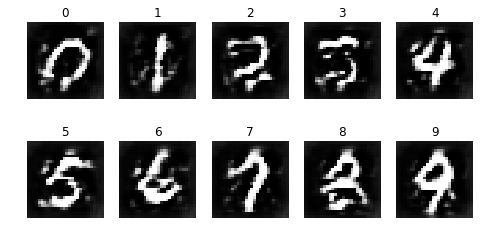

In [ ]:
generator.save_params('gen')
discriminator.save_params('disc')

## Viewing the generated frames as an animation

In [ ]:
from IPython.display import HTML
import matplotlib.animation as animation
fig=plt.figure(figsize=(12, 6))
im = plt.imshow(frames[0], animated=True)
idx=0
def update_fn(img):
    im.set_array(img)
    return im,
ani = animation.FuncAnimation(fig,update_fn, frames=frames, repeat=False)
HTML(ani.to_jshtml())

In [ ]:
ani.save('animation2.gif', writer='imagemagick')